In [2]:
!pip install catboost

     |████████████████████████████████| 65.7 MB 345 kB/s eta 0:00:013


# Imports

In [40]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import collections

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import catboost
from catboost import CatBoostClassifier, Pool



# Constants

In [4]:
TARGETS = ['main_screen', 'invest', 'statement', 'phone_money_transfer',
       'own_transfer', 'credit_info', 'chat', 'card2card_transfer',
       'mobile_recharge', 'card_recharge']

# Data Load

In [29]:
train_target = pd.read_csv("alfabattle2_abattle_train_target.csv")

test_target = pd.read_csv("alfabattle2_prediction_session_timestamp.csv")
test_target["test"] = True

dataset = pd.concat([test_target, train_target], axis=0).reset_index(drop=True)
dataset.sort_values("timestamp", inplace=True)
dataset["test"].replace(np.NaN, False, inplace=True)
# dataset.loc[dataset["test"], "multi_class_target"] = "statement"
dataset.loc[dataset["test"], "session_id"] = np.arange(len(dataset.loc[dataset["test"], "session_id"]))
dataset["timestamp"] = pd.to_datetime(dataset["timestamp"])
dataset

client_pin           timestamp   test  \
3543389  989f645a00e3e8a179036cf5fd5be29d 2020-01-01 00:00:00  False   
218041   70783113e4f4117935d9f746237fce3e 2020-01-01 00:00:00  False   
593976   586fe605f61e81581efe72d9d3dc237d 2020-01-01 00:00:01  False   
2729012  c825cc9d1dfefe1fbc0fa1ead60fe2e1 2020-01-01 00:00:23  False   
3528582  29928aba9d9bbf5e0377ddc6ec6f5294 2020-01-01 00:00:35  False   
...                                   ...                 ...    ...   
79263    4e46e206d38dcb7af41d9ced20d50ac2 2020-09-30 23:41:47   True   
79264    5b59bf5bd1e07775b1bc95dd7151d2cd 2020-09-30 23:43:25   True   
79265    94bcc852dd7f806f6c733056d1b0be7b 2020-09-30 23:50:37   True   
79266    2061f779928217eea2878fd3b605fafd 2020-09-30 23:53:03   True   
79267    e2f0cede9e3bc3d6ed7c77c4e08af136 2020-09-30 23:58:32   True   

                               session_id multi_class_target  
3543389  f99d13f31091099672e51c1a02e4c567          statement  
218041   da4ab6bb6795a4eb6458b88af7fb2367    mobile_recharge  
593976   69301aa932f73dec3355b803a63c39fe          statement  
2729012  c6ae8307a0214b526a0e6fca3a9b80f5          statement  
3528582  3fd49317a617d521e0865496ec797550    mobile_recharge  
...                                   ...                ...  
79263                               79263                NaN  
79264                               79264                NaN  
79265                               79265                NaN  
79266                               79266                NaN  
79267                               79267                NaN  

[5144618 rows x 5 columns]

In [6]:
dataset.groupby(["multi_class_target"]).cumcount()

3543389        0
218041         0
593976         1
2729012        2
3528582        1
           ...  
79263      79263
79264      79264
79265      79265
79266      79266
79267      79267
Length: 5144618, dtype: int64

In [7]:
train_target.sort_values("timestamp", inplace=True)
train_target.head()

session_id                        client_pin  \
138773   da4ab6bb6795a4eb6458b88af7fb2367  70783113e4f4117935d9f746237fce3e   
3464121  f99d13f31091099672e51c1a02e4c567  989f645a00e3e8a179036cf5fd5be29d   
514708   69301aa932f73dec3355b803a63c39fe  586fe605f61e81581efe72d9d3dc237d   
2649744  c6ae8307a0214b526a0e6fca3a9b80f5  c825cc9d1dfefe1fbc0fa1ead60fe2e1   
3449314  3fd49317a617d521e0865496ec797550  29928aba9d9bbf5e0377ddc6ec6f5294   

                   timestamp multi_class_target  
138773   2020-01-01 00:00:00    mobile_recharge  
3464121  2020-01-01 00:00:00          statement  
514708   2020-01-01 00:00:01          statement  
2649744  2020-01-01 00:00:23          statement  
3449314  2020-01-01 00:00:35    mobile_recharge

In [8]:
train_target.groupby("client_pin")["session_id"].count().reset_index()["session_id"].describe()

count    79268.000000
mean        63.901574
std         85.280433
min          1.000000
25%         14.000000
50%         35.000000
75%         80.000000
max       1646.000000
Name: session_id, dtype: float64

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='session_id'>

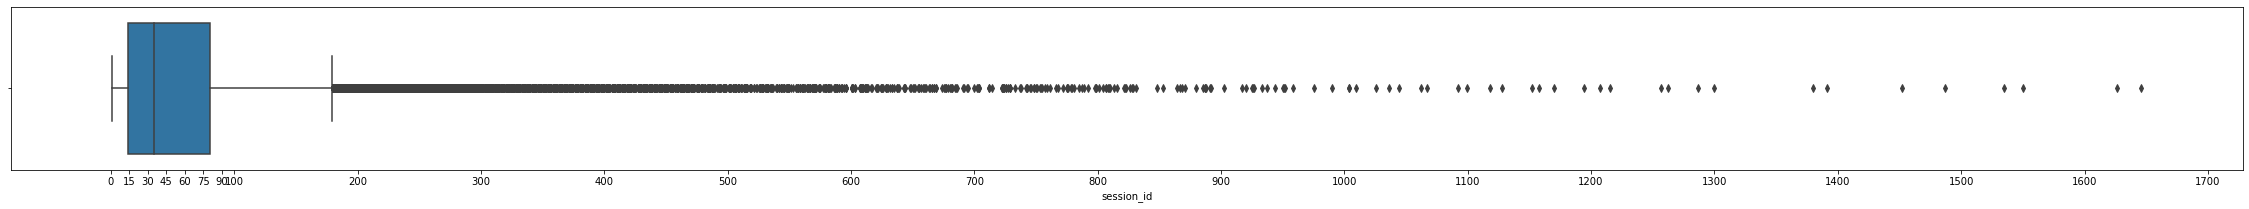

In [9]:
plt.figure(figsize=(40, 3))
plt.gca().set_xticks(list(range(0, 100, 15)) + list(range(100, 2000, 100)))
sns.boxplot(train_target.groupby("client_pin")["session_id"].count().reset_index()["session_id"])

# Data Train\Val split

In [10]:
train_target.head()

session_id                        client_pin  \
138773   da4ab6bb6795a4eb6458b88af7fb2367  70783113e4f4117935d9f746237fce3e   
3464121  f99d13f31091099672e51c1a02e4c567  989f645a00e3e8a179036cf5fd5be29d   
514708   69301aa932f73dec3355b803a63c39fe  586fe605f61e81581efe72d9d3dc237d   
2649744  c6ae8307a0214b526a0e6fca3a9b80f5  c825cc9d1dfefe1fbc0fa1ead60fe2e1   
3449314  3fd49317a617d521e0865496ec797550  29928aba9d9bbf5e0377ddc6ec6f5294   

                   timestamp multi_class_target  
138773   2020-01-01 00:00:00    mobile_recharge  
3464121  2020-01-01 00:00:00          statement  
514708   2020-01-01 00:00:01          statement  
2649744  2020-01-01 00:00:23          statement  
3449314  2020-01-01 00:00:35    mobile_recharge

In [51]:
_X = ExtractorJustInTimeFlag()(dataset)

  0%|          | 0/10 [00:00<?, ?it/s]

Doing dumb



 10%|█         | 1/10 [07:06<1:03:54, 426.09s/it]

Dumb is done
Doing dumb



 20%|██        | 2/10 [07:23<40:27, 303.39s/it]  

Dumb is done
Doing dumb



 30%|███       | 3/10 [10:30<31:20, 268.61s/it]

Dumb is done
Doing dumb



 40%|████      | 4/10 [11:27<20:30, 205.10s/it]

Dumb is done
Doing dumb



 50%|█████     | 5/10 [12:30<13:31, 162.32s/it]

Dumb is done
Doing dumb



 60%|██████    | 6/10 [14:14<09:39, 144.95s/it]

Dumb is done
Doing dumb



 70%|███████   | 7/10 [15:07<05:52, 117.47s/it]

Dumb is done
Doing dumb



 80%|████████  | 8/10 [15:56<03:13, 96.76s/it] 

Dumb is done
Doing dumb



 90%|█████████ | 9/10 [16:58<01:26, 86.45s/it]

Dumb is done
Doing dumb



  0%|          | 0/10 [00:00<?, ?it/s]

Dumb is done
Doing dumb



 10%|█         | 1/10 [07:03<1:03:34, 423.84s/it]

Dumb is done
Doing dumb



 20%|██        | 2/10 [07:20<40:14, 301.77s/it]  

Dumb is done
Doing dumb



 30%|███       | 3/10 [10:26<31:09, 267.06s/it]

Dumb is done
Doing dumb



 40%|████      | 4/10 [11:23<20:23, 203.87s/it]

Dumb is done
Doing dumb



 50%|█████     | 5/10 [12:25<13:26, 161.36s/it]

Dumb is done
Doing dumb



 60%|██████    | 6/10 [14:08<09:35, 143.80s/it]

Dumb is done
Doing dumb



 70%|███████   | 7/10 [15:01<05:50, 116.73s/it]

Dumb is done
Doing dumb



 80%|████████  | 8/10 [15:50<03:12, 96.31s/it] 

Dumb is done
Doing dumb



 90%|█████████ | 9/10 [16:52<01:26, 86.08s/it]

Dumb is done
Doing dumb



  0%|          | 0/10 [00:00<?, ?it/s]

Dumb is done
Doing dumb



 10%|█         | 1/10 [07:04<1:03:40, 424.47s/it]

Dumb is done
Doing dumb



 20%|██        | 2/10 [07:21<40:18, 302.34s/it]  

Dumb is done
Doing dumb



 30%|███       | 3/10 [10:29<31:15, 267.87s/it]

Dumb is done
Doing dumb



 40%|████      | 4/10 [11:26<20:28, 204.73s/it]

Dumb is done
Doing dumb



 50%|█████     | 5/10 [12:29<13:30, 162.16s/it]

Dumb is done
Doing dumb



 60%|██████    | 6/10 [14:13<09:38, 144.66s/it]

Dumb is done
Doing dumb



 70%|███████   | 7/10 [15:07<05:52, 117.37s/it]

Dumb is done
Doing dumb



 80%|████████  | 8/10 [15:56<03:14, 97.01s/it] 

Dumb is done
Doing dumb



 90%|█████████ | 9/10 [16:59<01:26, 86.78s/it]

Dumb is done
Doing dumb



100%|██████████| 3/3 [52:35<00:00, 1051.85s/it]

Dumb is done


In [62]:
pd.concat([dataset, _X], axis=1)

client_pin           timestamp   test  \
3543389  989f645a00e3e8a179036cf5fd5be29d 2020-01-01 00:00:00  False   
218041   70783113e4f4117935d9f746237fce3e 2020-01-01 00:00:00  False   
593976   586fe605f61e81581efe72d9d3dc237d 2020-01-01 00:00:01  False   
2729012  c825cc9d1dfefe1fbc0fa1ead60fe2e1 2020-01-01 00:00:23  False   
3528582  29928aba9d9bbf5e0377ddc6ec6f5294 2020-01-01 00:00:35  False   
...                                   ...                 ...    ...   
79263    4e46e206d38dcb7af41d9ced20d50ac2 2020-09-30 23:41:47   True   
79264    5b59bf5bd1e07775b1bc95dd7151d2cd 2020-09-30 23:43:25   True   
79265    94bcc852dd7f806f6c733056d1b0be7b 2020-09-30 23:50:37   True   
79266    2061f779928217eea2878fd3b605fafd 2020-09-30 23:53:03   True   
79267    e2f0cede9e3bc3d6ed7c77c4e08af136 2020-09-30 23:58:32   True   

                               session_id multi_class_target  day  \
3543389  f99d13f31091099672e51c1a02e4c567          statement    1   
218041   da4ab6bb6795a4eb6458b88af7fb2367    mobile_recharge    1   
593976   69301aa932f73dec3355b803a63c39fe          statement    1   
2729012  c6ae8307a0214b526a0e6fca3a9b80f5          statement    1   
3528582  3fd49317a617d521e0865496ec797550    mobile_recharge    1   
...                                   ...                ...  ...   
79263                               79263                NaN   30   
79264                               79264                NaN   30   
79265                               79265                NaN   30   
79266                               79266                NaN   30   
79267                               79267                NaN   30   

         day_of_week  hour  f_day_main_screen  f_day_invest  ...  \
3543389            2     0              False         False  ...   
218041             2     0              False         False  ...   
593976             2     0              False         False  ...   
2729012            2     0              False         False  ...   
3528582            2     0              False         False  ...   
...              ...   ...                ...           ...  ...   
79263              2    23              False         False  ...   
79264              2    23              False         False  ...   
79265              2    23              False         False  ...   
79266              2    23              False         False  ...   
79267              2    23              False         False  ...   

         f_hour_main_screen  f_hour_invest  f_hour_statement  \
3543389               False          False             False   
218041                False          False             False   
593976                False          False             False   
2729012               False          False             False   
3528582               False          False             False   
...                     ...            ...               ...   
79263                 False          False             False   
79264                 False          False             False   
79265                 False          False             False   
79266                 False          False             False   
79267                 False          False             False   

         f_hour_phone_money_transfer  f_hour_own_transfer  f_hour_credit_info  \
3543389                        False                False               False   
218041                         False                False               False   
593976                         False                False               False   
2729012                        False                False               False   
3528582                        False                False               False   
...                              ...                  ...                 ...   
79263                          False                False               False   
79264                          False                False               False   
79265                 

In [59]:
_X[_X.f_day_main_screen]

day  day_of_week  hour  f_day_main_screen  f_day_invest  \
4909785    1            2     0               True         False   
5042823    1            2     0               True         False   
4308095    1            2     0               True         False   
3824310    1            2     0               True         False   
1576480    1            2     0               True         False   
...      ...          ...   ...                ...           ...   
2109575   30            2    17               True         False   
279589    30            2    18               True         False   
1405130   30            2    18               True         False   
2497774   30            2    18               True         False   
5032213   30            2    22               True         False   

         f_day_statement  f_day_phone_money_transfer  f_day_own_transfer  \
4909785            False                       False               False   
5042823            False                       False               False   
4308095            False                       False               False   
3824310            False                       False               False   
1576480            False                       False               False   
...                  ...                         ...                 ...   
2109575            False                       False               False   
279589             False                       False               False   
1405130            False                       False               False   
2497774            False                       False               False   
5032213            False                       False               False   

         f_day_credit_info  f_day_chat  ...  f_hour_main_screen  \
4909785              False       False  ...                True   
5042823              False       False  ...                True   
4308095              False       False  ...                True   
3824310              False       False  ...                True   
1576480              False       False  ...                True   
...                    ...         ...  ...                 ...   
2109575              False       False  ...               False   
279589               False       False  ...               False   
1405130              False       False  ...               False   
2497774              False       False  ...               False   
5032213              False       False  ...               False   

         f_hour_invest  f_hour_statement  f_hour_phone_money_transfer  \
4909785          False             False                        False   
5042823          False             False                        False   
4308095          False             False                        False   
3824310          False             False                        False   
1576480          False             False                        False   
...                ...               ...                          ...   
2109575          False             False                        False   
279589           False             False                        False   
1405130          False             False                        False   
2497774          False             False                        False   
5032213          False             False                        False   

         f_hour_own_transfer  f_hour_credit_info  f_hour_chat  \
4909785                False               False        False   
5042823                False               False        False   
4308095                False               False        False   
3824310                False               False        False   
1576480                False               False        False   
...                      ...                 ...          ...   
2109575                False               False        False   
279589                 False               False        False   
1405130     

In [60]:
class ExtractorJustInTimeFlag():
    def __init__(self):
        pass
        
    def __call__(self, X: pd.DataFrame) -> pd.DataFrame:
        """  Create flags targets*time_features till the moment
        """
        X_new = X.copy()
        columns_names = X_new.columns
        X_new, date_features = self.retrieve_times(X_new)
        
#         for d in date_features:
#             #X_new[f"count_per_target_{d}"] = X_new.groupby(["client_pin", "multi_class_target", d]).cumcount()
#             X_new[f"count_per_target_{d}_max"] = X_new.groupby(["client_pin", "multi_class_target"])[d].transform(self.dumb)
            
#         
#         for t in TARGETS:
#             for d in date_features: 
#                 columns_names.append(f"f_{d}_{t}")
#                 X_new[f"f_{d}_{t}"] = False
#                 X_new[f"f_{d}_{t}"] = X_new.loc[X_new.multi_class_target == t, f"count_per_target_{d}_max"] == X_new.loc[X_new.multi_class_target == t, d]
                
        columns_names += date_features
        for d in tqdm(date_features): 
            for t in tqdm(TARGETS):
                mask = X_new.multi_class_target == t
                X_new.loc[mask, f"count_per_{t}_{d}_max"] = np.NaN
                print("Doing dumb")
                X_new.loc[mask, f"count_per_{t}_{d}_max"] = X_new.loc[mask].groupby(["client_pin"])[d].transform(self.dumb)
                print("Dumb is done")
                X_new.loc[mask, f"count_per_{t}_{d}_max"] = X_new.loc[mask, f"count_per_{t}_{d}_max"].ffill()
                
                columns_names.append(f"f_{d}_{t}")
                X_new[f"f_{d}_{t}"] = X_new[f"count_per_{t}_{d}_max"] == X_new[d]
        return X_new[columns_names]

    
    def retrieve_times(self, X: pd.DataFrame):
        X["f_day"] = X["timestamp"].dt.day        
        X["f_dayofweek"] = X["timestamp"].dt.dayofweek
        #X["f_weekend"] = pd.apply(X["day_of_week"]
        X["f_hour"] = X["timestamp"].dt.hour
        return X, ["f_day", "f_dayofweek", "f_hour"]

    def dumb(self, S: pd.Series) -> pd.Series:
        l = []
        for i in range(1, len(S)+1):
            l.append(S[:i].mode()[0])
        return pd.Series(l).shift()
    
    def stub(self, S: pd.Series) -> pd.Series:
        return S
        
    
    def circumflex(X: pd.DataFrame) -> pd.DataFrame:
        pass
        
    
    def __repr__(self):
        return f"ExtractorPeriodFlag"

class ExtractorLastNTarget():
    def __init__(self, by: str, target: str, num: int=10):
        self.num = num
        self.by = by
        self.target = target
        
    def __call__(self, X: pd.DataFrame) -> pd.DataFrame:
        """  Add last <num> <target> feature
            grouped <by> field
        """
        X_new = X.copy()
        columns = []
        for i in range(1, self.num+1):
            columns.append(f"f_last_{i}")
            X_new[f"f_last_{i}"] = X_new.groupby(self.by)[self.target].shift(i)
        X_new[columns] = X_new[columns].replace(np.NaN, "NaN") 
        return X_new   
    
    def __repr__(self):
        return f"LastNTarget {self.num}"
    
    
class ExtractorClientTargetFreq():      
    def __init__(self, column: str):
        self.column = column
        
    def __call__(self, X: pd.DataFrame) -> pd.DataFrame:
        """  Add client frequency till the moment
        """
        X_new = X.copy()
        client_freq, columns = self.prepare_user_freq_matrix(X_new)        
        X_new[columns] = client_freq[columns]  
        return X_new  
    
    def prepare_user_freq_matrix(self, X: pd.DataFrame) -> pd.DataFrame:
        X_new = X.copy()
        X_new["f_total"] = X_new.groupby("client_pin")["session_id"].cumcount()
        X_new["count_per_target"] = X_new.groupby(["client_pin", "multi_class_target"]).cumcount()
        # X_new["count_per_target"] = X_new.groupby(["client_pin", "multi_class_target"])["session_id"].cumcount()
        X_new["f_total"] = pd.to_numeric(X_new["f_total"], downcast="unsigned")
        X_new["count_per_target"] = pd.to_numeric(X_new["count_per_target"], downcast="unsigned")
        columns_names = ["f_total"]
        for t in X_new[self.column].dropna().unique():
            X_new.loc[X_new[self.column] == t, f"cum_{t}"] = X_new.loc[X_new[self.column] == t, "count_per_target"]            
            X_new[f"cum_{t}"] = X_new.groupby("client_pin")[f"cum_{t}"].fillna(method='ffill')
            X_new[f"cum_{t}"] = X_new[f"cum_{t}"].replace(np.NaN, 0)
            X_new[f"f_freq_{t}"] = X_new[f"cum_{t}"].div(X_new["f_total"])  
            X_new[f"f_freq_{t}"] = X_new[f"f_freq_{t}"].replace(np.NaN, 0)
            columns_names.append(f"f_freq_{t}")
        return X_new, columns_names
    
    def __repr__(self):
        return f"ClientTargetFreq"
    
    
class FilterMinTotal():
    """ Filter dataset by "f_total" field. 
    If <remove_index> specified  will not removed client 
    with max_f_total < <filter_min_target>
    """
    def __init__(self, index: str="client_pin", target: str="f_total", filter_min_target: int=20, remove_index: bool=False):
        self.index = index
        self.target = target
        self.filter_min_target = filter_min_target
        self.remove_index = remove_index
        
    def __call__(self, X: pd.DataFrame) -> pd.DataFrame:
        X_copy = X.copy()             
        X_cleared = X_copy[X_copy[self.target] >= self.filter_min_target]        
        index_array = X_copy[self.index].unique()  
        cleared_index_array = X_cleared[self.index].unique() 
        removed_index_array = np.setxor1d(index_array, cleared_index_array)
        X_filtered = X_cleared
        if len(removed_index_array) > 0:
            if self.remove_index:                 
                print(f"{self.__class__.__name__}: {len(removed_index_array)} clients were removed")
            else:
                X_copy[f"max_{self.target}"] = X_copy.groupby(self.index)[self.target].max()                 
                X_filtered = X_copy[(X_copy[self.target] >= self.filter_min_target) | (X_copy[f"max_{self.target}"] == X_copy[self.target])]  
                X_filtered = X_filtered.drop(f"max_{self.target}", axis=1)
                print(f"{self.__class__.__name__}: {len(removed_index_array)} clients were removed and merged back")
        return X_filtered
    
    def __repr__(self):
        return f"FilterMinTotal: \n {self.target} >= {self.filter_min_target} by={self.index}"
        
def create_feature(X: pd.DataFrame, feature_gen_list: list) -> pd.DataFrame:
    """ Create dataset features
    
    Attributes
    ----------
    X: pd.DataFrame
     initial feature
    y: np.ndarray
     target
    feature_config: dict
     config with feature generatation functions
    """
    X_new = X.copy()
    for fg in feature_gen_list:
        print(f"Adding feature with {fg}:-------")
        X_new = fg(X_new)
    return X_new

def filter_feature(X: pd.DataFrame, feature_filter_list: list) -> pd.DataFrame:
    X_filtered = X.copy()
    for ff in feature_filter_list:
        print(f"{ff}")
        X_filtered = ff(X_filtered)
    return X_filtered

In [12]:
feature_generator = [
    ExtractorLastNTarget(by="client_pin",
                target="multi_class_target",
                num=30),
    ExtractorClientTargetFreq(column="multi_class_target")
]

dataset_featured = create_feature(dataset, feature_generator)

Adding feature with LastNTarget 30:-------
Adding feature with ClientTargetFreq:-------


In [63]:
dataset_featured = pd.concat([dataset_featured, _X], axis=1)

In [83]:
dataset_featured.to_csv("dataset.csv", index=False)

In [64]:
feature_generator_filter = [
    #FilterMinTotal(target="f_total", filter_min_target=20)
]

dataset_for_train = filter_feature(dataset_featured[~dataset_featured["test"]], feature_generator_filter)
dataset_for_train.f_total = dataset_for_train.f_total.astype('int64')
dataset_for_train["from_end"] = dataset_for_train.groupby("client_pin").f_total.transform(lambda x: x[::-1])
dataset_for_train["sample_weight"] = 0.99 ** dataset_for_train.from_end 

In [65]:
dataset_featured.columns

Index(['client_pin', 'timestamp', 'test', 'session_id', 'multi_class_target',
       'f_last_1', 'f_last_2', 'f_last_3', 'f_last_4', 'f_last_5', 'f_last_6',
       'f_last_7', 'f_last_8', 'f_last_9', 'f_last_10', 'f_last_11',
       'f_last_12', 'f_last_13', 'f_last_14', 'f_last_15', 'f_last_16',
       'f_last_17', 'f_last_18', 'f_last_19', 'f_last_20', 'f_last_21',
       'f_last_22', 'f_last_23', 'f_last_24', 'f_last_25', 'f_last_26',
       'f_last_27', 'f_last_28', 'f_last_29', 'f_last_30', 'f_total',
       'f_freq_statement', 'f_freq_mobile_recharge',
       'f_freq_phone_money_transfer', 'f_freq_chat', 'f_freq_invest',
       'f_freq_main_screen', 'f_freq_own_transfer', 'f_freq_card_recharge',
       'f_freq_credit_info', 'f_freq_card2card_transfer', 'day', 'day_of_week',
       'hour', 'f_day_main_screen', 'f_day_invest', 'f_day_statement',
       'f_day_phone_money_transfer', 'f_day_own_transfer', 'f_day_credit_info',
       'f_day_chat', 'f_day_card2card_transfer', 'f_day_mo

# Learn a model

In [72]:
features_list = [c for c in dataset_for_train.columns if c.startswith("f_")] + ['day', 'day_of_week', 'hour']
features_list

cat_features = [c for c in features_list if c.startswith("f_last")] + ['day', 'day_of_week',
       'hour', 'f_day_main_screen', 'f_day_invest', 'f_day_statement',
       'f_day_phone_money_transfer', 'f_day_own_transfer', 'f_day_credit_info',
       'f_day_chat', 'f_day_card2card_transfer', 'f_day_mobile_recharge',
       'f_day_card_recharge', 'f_day_of_week_main_screen',
       'f_day_of_week_invest', 'f_day_of_week_statement',
       'f_day_of_week_phone_money_transfer', 'f_day_of_week_own_transfer',
       'f_day_of_week_credit_info', 'f_day_of_week_chat',
       'f_day_of_week_card2card_transfer', 'f_day_of_week_mobile_recharge',
       'f_day_of_week_card_recharge', 'f_hour_main_screen', 'f_hour_invest',
       'f_hour_statement', 'f_hour_phone_money_transfer',
       'f_hour_own_transfer', 'f_hour_credit_info', 'f_hour_chat',
       'f_hour_card2card_transfer', 'f_hour_mobile_recharge',
       'f_hour_card_recharge']
num_features = ['f_total',
 'f_freq_mobile_recharge',
 'f_freq_statement',
 'f_freq_phone_money_transfer',
 'f_freq_chat',
 'f_freq_invest',
 'f_freq_main_screen',
 'f_freq_own_transfer',
 'f_freq_card_recharge',
 'f_freq_credit_info',
 'f_freq_card2card_transfer']


In [73]:
features_list

['f_last_1',
 'f_last_2',
 'f_last_3',
 'f_last_4',
 'f_last_5',
 'f_last_6',
 'f_last_7',
 'f_last_8',
 'f_last_9',
 'f_last_10',
 'f_last_11',
 'f_last_12',
 'f_last_13',
 'f_last_14',
 'f_last_15',
 'f_last_16',
 'f_last_17',
 'f_last_18',
 'f_last_19',
 'f_last_20',
 'f_last_21',
 'f_last_22',
 'f_last_23',
 'f_last_24',
 'f_last_25',
 'f_last_26',
 'f_last_27',
 'f_last_28',
 'f_last_29',
 'f_last_30',
 'f_total',
 'f_freq_statement',
 'f_freq_mobile_recharge',
 'f_freq_phone_money_transfer',
 'f_freq_chat',
 'f_freq_invest',
 'f_freq_main_screen',
 'f_freq_own_transfer',
 'f_freq_card_recharge',
 'f_freq_credit_info',
 'f_freq_card2card_transfer',
 'f_day_main_screen',
 'f_day_invest',
 'f_day_statement',
 'f_day_phone_money_transfer',
 'f_day_own_transfer',
 'f_day_credit_info',
 'f_day_chat',
 'f_day_card2card_transfer',
 'f_day_mobile_recharge',
 'f_day_card_recharge',
 'f_day_of_week_main_screen',
 'f_day_of_week_invest',
 'f_day_of_week_statement',
 'f_day_of_week_phone_mone

In [74]:
assert dataset_for_train.timestamp.is_monotonic
# Add Last 2 samples for each user to validation
X_train = dataset_for_train.loc[dataset_for_train.from_end > 1, features_list]
y_train = dataset_for_train.loc[dataset_for_train.from_end > 1, "multi_class_target"]

X_val = dataset_for_train.loc[dataset_for_train.from_end <= 1, features_list]
y_val = dataset_for_train.loc[dataset_for_train.from_end <= 1, "multi_class_target"]


# X_train, X_val, y_train, y_val = train_test_split(dataset_for_train[features_list],
#                                                   dataset_for_train.multi_class_target,
#                                                   train_size=0.8, random_state=42, shuffle=False)
pool_train = Pool(data=X_train, label=y_train, cat_features=cat_features)
pool_val   = Pool(data=X_val, label=y_val, cat_features=cat_features)
pool_test  = Pool(data=dataset_featured.loc[dataset_featured["test"], features_list], cat_features=cat_features)

In [76]:
LOAD_MODEL = False

model = CatBoostClassifier(
    iterations=50,
    learning_rate=0.1,
    #auto_class_weights="Balanced",
    thread_count=50,
    # save_snapshot=True
    # loss_function='CrossEntropy'
)

if LOAD_MODEL:
    print("Model Loading...")
    model = model.load_model("model_09_01")
else:
    print("Model training...")
    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        verbose=False,
        plot=True,
    )
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model training...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True
Model params:
{'iterations': 50, 'learning_rate': 0.1, 'thread_count': 50}


In [81]:
model.save_model("model_17_01", format="cbm")

In [ ]:
dataset

In [85]:
metrics = model.eval_metrics(
    data=pool_val,
    metrics=['TotalF1:average=Macro;use_weights=False'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [28]:
LOAD_MODEL = False

model = CatBoostClassifier(
    iterations=50,
    learning_rate=0.1,
    #auto_class_weights="Balanced",
    thread_count=50,
    # save_snapshot=True
    # loss_function='CrossEntropy'
)

if LOAD_MODEL:
    print("Model Loading...")
    model = model.load_model("model_09_01")
else:
    print("Model training...")
    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        verbose=False,
        plot=True,
    )
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model training...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True
Model params:
{'iterations': 50, 'learning_rate': 0.1, 'thread_count': 50}


In [84]:
metrics = model.eval_metrics(
    data=pool_val,
    metrics=['TotalF1:average=Macro;use_weights=False'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [75]:
model_backed = model

In [45]:
val_pred_class = model.predict(pool_val, prediction_type="Class")
val_pred_proba = model.predict_proba(pool_val)

In [93]:
map_category = np.vectorize(lambda idx: model.classes_[idx])
val_pred_max_proba = np.argmax(val_pred_proba, axis=1)
val_pred_max_proba_class = map_category(val_pred_max_proba).reshape(-1, 1)

# Model prediction_type="Class" predicts only max prob
assert np.array_equal(val_pred_class, val_pred_max_proba_class)

In [103]:
conf_mat = pd.DataFrame(confusion_matrix(pool_val.get_label(), val_pred_class), 
                        index = model.classes_,
                        columns = model.classes_)

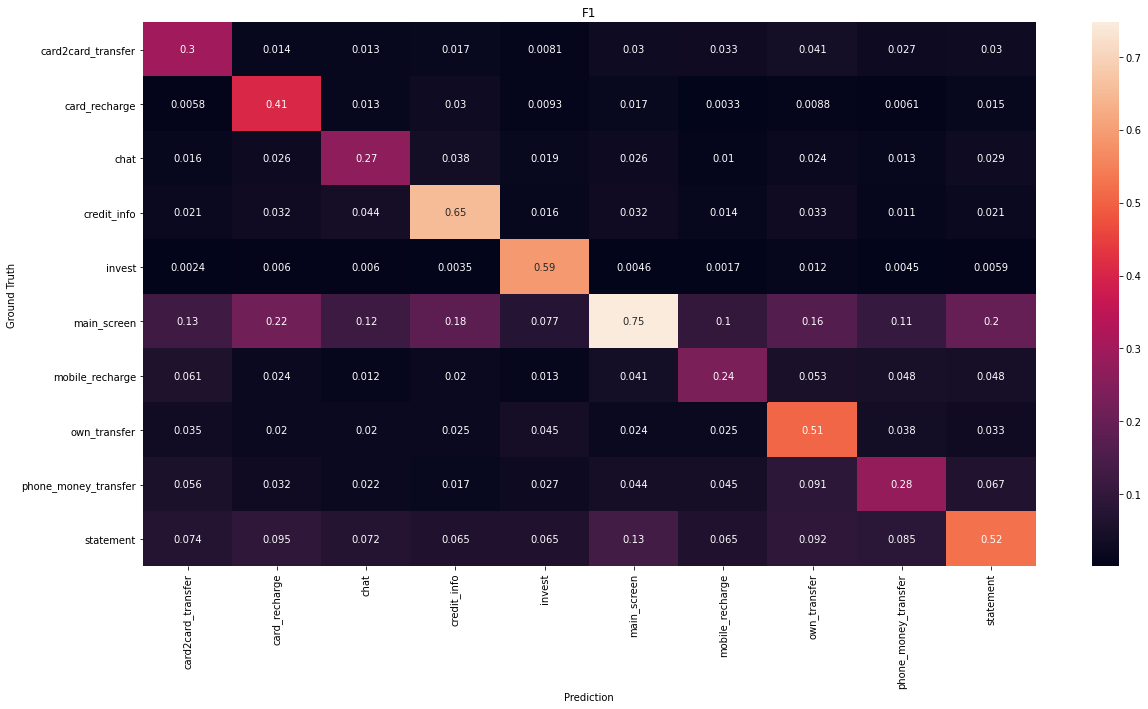

In [137]:
def f1_measure(precision, recall):
    return 2 * precision * recall / (precision + recall)

conf_mat_precision = conf_mat / conf_mat.sum(axis=0)
conf_mat_recall = conf_mat / conf_mat.sum(axis=1)
conf_mat_abs = conf_mat / conf_mat.sum().sum()
conf_mat_f1 = f1_measure(conf_mat_precision, conf_mat_recall)

plt.figure(figsize = (20,10))
ax = sns.heatmap(conf_mat_f1, annot=True)
ax.set(xlabel='Prediction', ylabel='Ground Truth', title="F1")
plt.show()

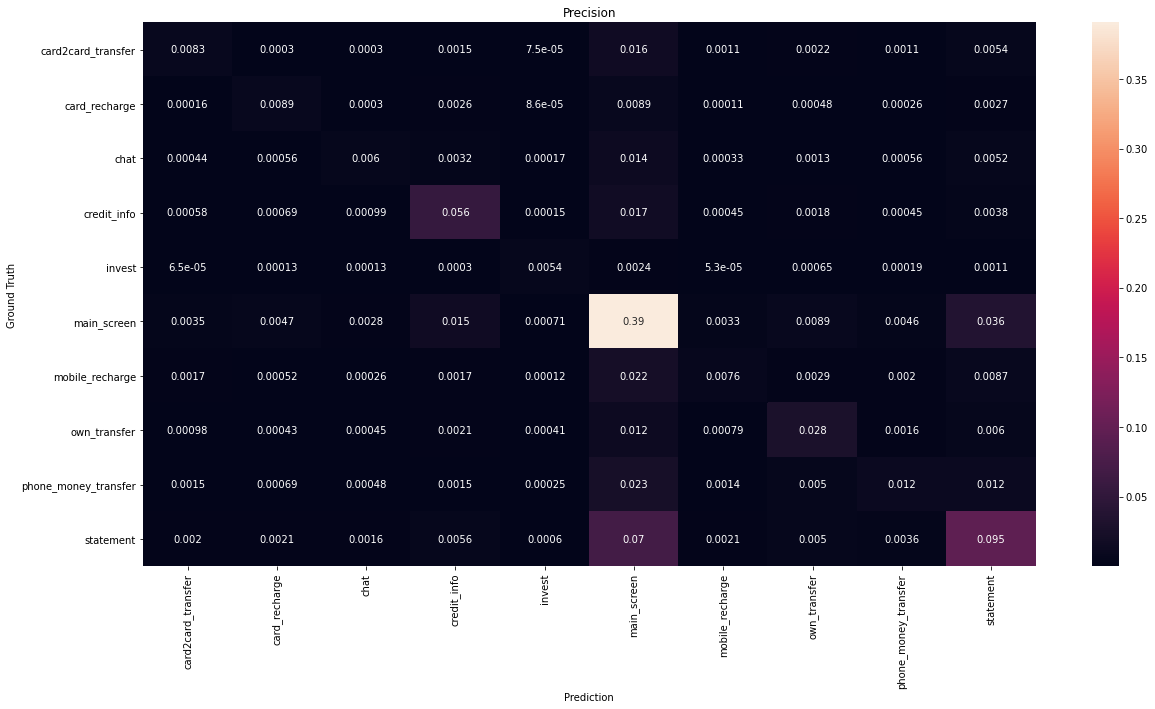

In [138]:
plt.figure(figsize = (20,10))
ax = sns.heatmap(conf_mat_abs, annot=True)
ax.set(xlabel='Prediction', ylabel='Ground Truth', title="Precision")
plt.show()

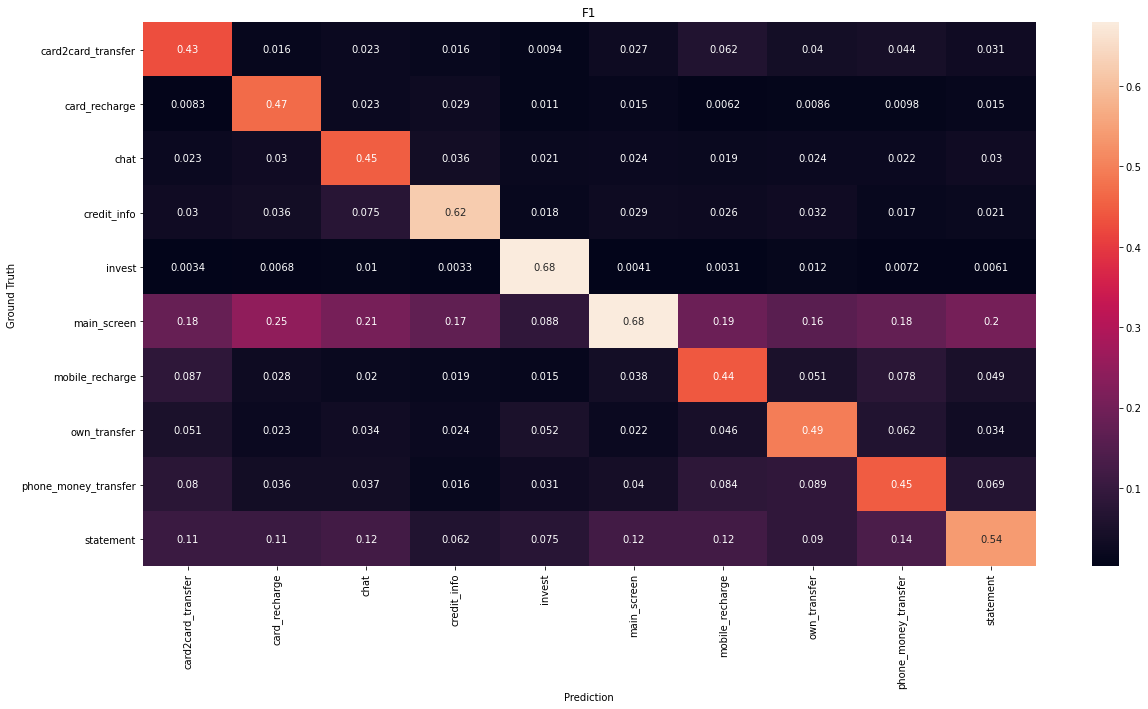

In [129]:
plt.figure(figsize = (20,10))
ax = sns.heatmap(conf_mat_precision, annot=True)
ax.set(xlabel='Prediction', ylabel='Ground Truth', title="Precision")
plt.show()

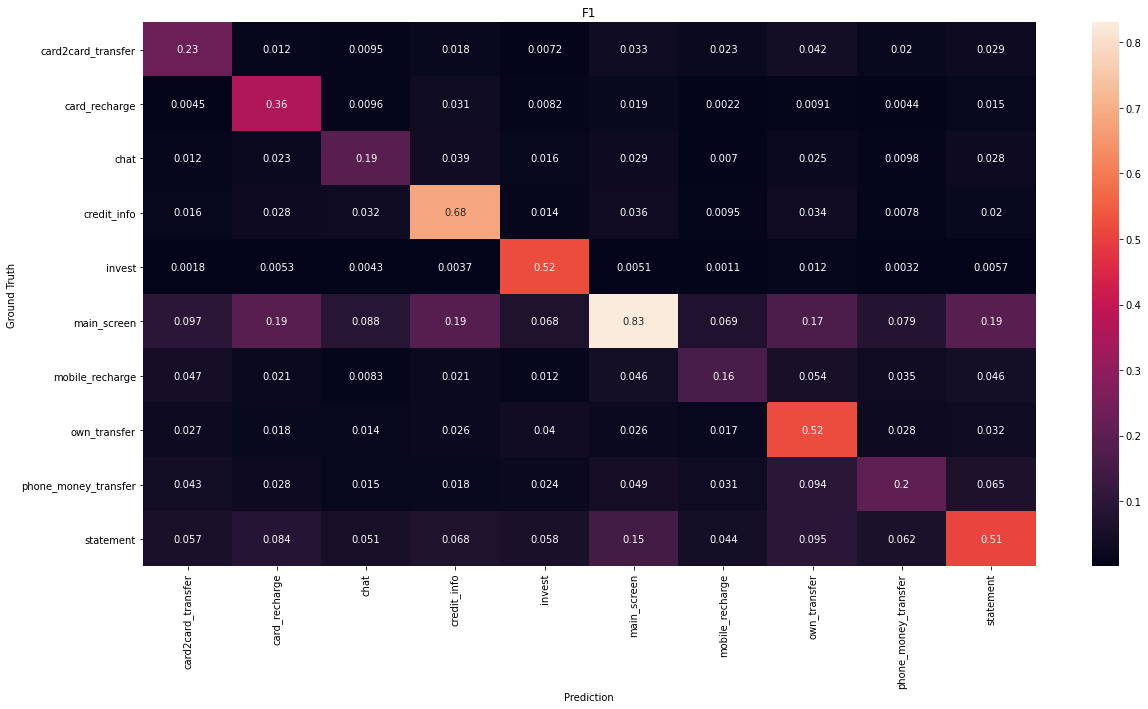

In [130]:
plt.figure(figsize = (20,10))
ax = sns.heatmap(conf_mat_recall, annot=True)
ax.set(xlabel='Prediction', ylabel='Ground Truth', title="Recall")
plt.show()

In [94]:
model.feature_importances_

array(None, dtype=object)

In [68]:
# model.save_model("model_09_01", format="cbm")

# Make Prediction

In [78]:
inference_model = CatBoostClassifier(
    iterations=50,
    learning_rate=0.1,
    # auto_class_weights="Balanced",
    thread_count=40,
    # save_snapshot=True
    # loss_function='CrossEntropy'
)

inference_model.fit(
    dataset_for_train[features_list], dataset_for_train.multi_class_target,
    cat_features=cat_features,
    # sample_weight=dataset_for_train.sample_weight,
    verbose=False,
    plot=True,
)

print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True
Model params:
{'iterations': 50, 'learning_rate': 0.1, 'thread_count': 50}


In [80]:
prediction = pd.read_csv("alfabattle2_abattle_sample_prediction.csv")
prediction["prediction"] = pd.Series(inference_model.predict(pool_test, prediction_type="Class").reshape(-1))
prediction.to_csv("submission.csv", index=False)
prediction

client_pin   prediction
0      f0c674b2bb4dc64be607029271d706ec  credit_info
1      90725b54ce77576883813d87749df6bd    statement
2      eb0f82d74c7b7bd5eafbd5b5f8cb3e2a    statement
3      831bf4c0ecccc55e536b8cfb9153d672    statement
4      3f1a5a1c492ce877af833113e59c5797  main_screen
...                                 ...          ...
79263  4e46e206d38dcb7af41d9ced20d50ac2    statement
79264  5b59bf5bd1e07775b1bc95dd7151d2cd  main_screen
79265  94bcc852dd7f806f6c733056d1b0be7b    statement
79266  2061f779928217eea2878fd3b605fafd  main_screen
79267  e2f0cede9e3bc3d6ed7c77c4e08af136  main_screen

[79268 rows x 2 columns]

# Lost in time and space

In [ ]:
    
#     def prepare_user_freq_matrix(self, X: pd.DataFrame) -> pd.DataFrame:
#         client_freq = pd.pivot_table(X, index=self.index,
#                        columns=self.column,
#                       values="session_id",
#                       aggfunc="count")
#         client_freq.replace(np.NaN, 0, inplace=True)
#         client_freq["total"] = client_freq.sum(axis=1)
#         client_freq = client_freq.div(client_freq["total"], axis=0)
#         client_freq.drop("total", axis=1, inplace=True)
#         client_freq.columns = [f"f_freq_{c}"for c in client_freq.columns]
#         client_freq.columns.name = None
#         client_freq = client_freq.reset_index()        
#         return client_freq